In [1]:
# Imports: matplotlib
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Imports: pandas etc
import numpy as np
import pandas as pd
import datetime as dt

import warnings
warnings.filterwarnings('ignore')


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Imports: Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine('sqlite:///Resources/hawaii.sqlite')
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
inspector = inspect(engine)

# reflect the tables
tbls = inspector.get_table_names()
tbls

['measurement', 'station']

In [6]:
# View all of the classes that automap found
Base = automap_base()
Base.prepare(autoload_with=engine)

Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Original Schema Visuals
print('--- TABLES ---')
print(tbls)

print('\n--- COLUMNS ---')

mCol = inspector.get_columns('measurement')
for c in mCol:
    print('measurement: ', c['name'], '  ::  ', c['type'])

sCol = inspector.get_columns('station')
for c in sCol:
    print('station: ', c['name'], '  ::  ', c['type'])
    

print('\n--- KEYS ---')

keys_m = inspector.get_pk_constraint('measurement')
keys_s = inspector.get_pk_constraint('station')

print(f'measurement constraints:  {keys_m}')
print(f'station constraints:  {keys_s}')


--- TABLES ---
['measurement', 'station']

--- COLUMNS ---
measurement:  id   ::   INTEGER
measurement:  station   ::   TEXT
measurement:  date   ::   TEXT
measurement:  prcp   ::   FLOAT
measurement:  tobs   ::   FLOAT
station:  id   ::   INTEGER
station:  station   ::   TEXT
station:  name   ::   TEXT
station:  latitude   ::   FLOAT
station:  longitude   ::   FLOAT
station:  elevation   ::   FLOAT

--- KEYS ---
measurement constraints:  {'constrained_columns': ['id'], 'name': None}
station constraints:  {'constrained_columns': ['id'], 'name': None}


In [10]:
# Find the most recent date in the data set.
maxDate = session.query(func.max(measurement.date)).scalar()
print(f'Most Recent Date:  {maxDate}')

Most Recent Date:  2017-08-23


<function matplotlib.pyplot.show(close=None, block=None)>

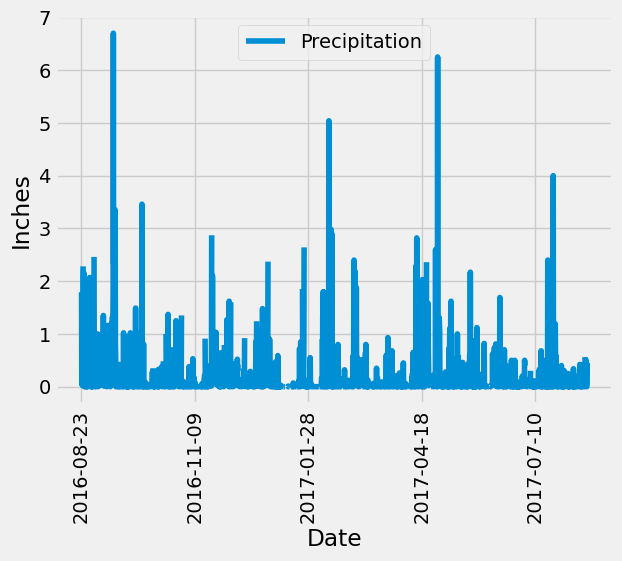

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Calculate the date one year from the last date in data set (converted max/min variables to datetime types)
maxDate = pd.to_datetime(maxDate)
minDate = maxDate - pd.DateOffset(years=1)

# Change max/min vars back to strings to match the dataset
maxDate = maxDate.strftime('%Y-%m-%d')
minDate = minDate.strftime('%Y-%m-%d')

# Create lists containing the given tables
OrigDataM = [measurement.id,#                                                                    OrigData variables defined
       measurement.station,
       measurement.date,
       measurement.prcp,
       measurement.tobs]
OrigDataS = [station.id,
       station.station,
       station.name,
       station.latitude,
       station.longitude,
       station.elevation]

# Perform a query to retrieve the data and precipitation scores
pastYr = session.query(*OrigDataM).\
    filter(measurement.date >= minDate)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
pastYr_df = pd.DataFrame(pastYr, columns=['id', 'station', 'date', 'prcp', 'tobs'])

# Filter down to only the required columns, and rename them
pcp_df = pastYr_df[['date', 'prcp']]
pcp_df.rename(columns={'date': 'Date', 'prcp': 'Precipitation'}, inplace=True)

# Sort the dataframe by date
pcp_df = pcp_df.sort_values('Date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
pcp_df.plot('Date', 'Precipitation')

# Customize the labels and ticks
plt.xticks(rotation=90)

plt.xlabel('Date')
plt.ylabel('Inches')

plt.show

In [12]:
# Original Dataset Visuals
print('--- MEASUREMENTS (first 5) ---')
for row in session.query(measurement.station, measurement.date, measurement.prcp, measurement.tobs).limit(5).all():
    print(row)

print('\n--- STATIONS (all) ---')
for row in session.query(station.station, station.name).all():
    print(row)


--- MEASUREMENTS (first 5) ---
('USC00519397', '2010-01-01', 0.08, 65.0)
('USC00519397', '2010-01-02', 0.0, 63.0)
('USC00519397', '2010-01-03', 0.0, 74.0)
('USC00519397', '2010-01-04', 0.0, 76.0)
('USC00519397', '2010-01-06', None, 73.0)

--- STATIONS (all) ---
('USC00519397', 'WAIKIKI 717.2, HI US')
('USC00513117', 'KANEOHE 838.1, HI US')
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US')
('USC00517948', 'PEARL CITY, HI US')
('USC00518838', 'UPPER WAHIAWA 874.3, HI US')
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US')
('USC00519281', 'WAIHEE 837.5, HI US')
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US')
('USC00516128', 'MANOA LYON ARBO 785.2, HI US')


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
pcp_df['Precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
# NOTE: Because I didn't create these datasets, I'm grabbing counts for both tables, hoping for a match
ttl_stationsM = session.query(func.count(measurement.station.distinct())).scalar()
print(f'Total Stations in the measurement dataset:  {ttl_stationsM}')

ttl_stationsS = session.query(func.count(station.station.distinct())).scalar()
print(f'Total Stations in the station dataset:  {ttl_stationsS}')

Total Stations in the measurement dataset:  9
Total Stations in the station dataset:  9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Create a list to hold the station & counts, then create a list of stations from the Stations table
station_counts = []
stations = session.query(station).all()

# Find the count for each station
for s in stations:
    station_query = session.query(measurement).\
                            filter(measurement.station == s.station).\
                            count()
    station_counts.append((s.station, station_query))

# Sort the station_counts list by count, descending
station_counts.sort(key=lambda x: x[1], reverse=True)
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Set a variable to the most active station from above
most_active_station = station_counts[0][0]

# Query for lowest temp
low_query = session.query(*OrigDataM).\
    filter(measurement.station == most_active_station).\
    order_by(measurement.tobs)

print(f'Lowest Temp at station {low_query[0].station}: {low_query[0].tobs}')

# Query for highest temp
high_query = session.query(*OrigDataM).\
    filter(measurement.station == most_active_station).\
    order_by(desc(measurement.tobs))

print(f'Highest Temp at station {high_query[0].station}: {high_query[0].tobs}')

# Query for average temp
avg_query = session.query(func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).scalar()

print(f'Average Temp: {avg_query}')


Lowest Temp at station USC00519281: 54.0
Highest Temp at station USC00519281: 85.0
Average Temp: 71.66378066378067


Text(0, 0.5, 'Frequency')

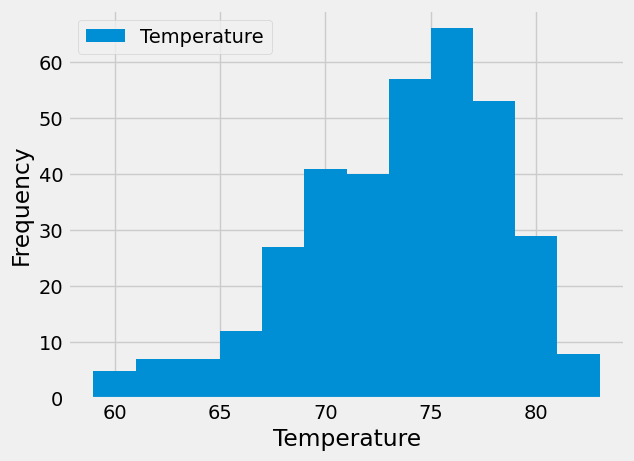

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
pastYr_active = session.query(*OrigDataM).\
    filter(measurement.date >= minDate).\
    filter(measurement.station == most_active_station)

# Save the query results as a Pandas DataFrame.
pastYr_active_df = pd.DataFrame(pastYr_active, columns=['id', 'station', 'date', 'prcp', 'tobs'])

# Filter down to only the required columns, and rename them
tobs_df = pastYr_active_df[['station', 'tobs']]
tobs_df.rename(columns={'station': 'Station', 'tobs': 'Temperature'}, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
tobs_df.plot.hist(y='Temperature', bins=12)

# Customize the labels
plt.xlabel('Temperature')
plt.ylabel('Frequency')


# Close Session

In [18]:
# Close Session
session.close()